In [1]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

import rasterio
from rasterio.windows import Window

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

In [3]:
EPOCHES = 20
BATCH_SIZE = 32
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])


In [4]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [5]:
train_mask = pd.read_csv('数据集/train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: '数据集/train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])

True


In [6]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

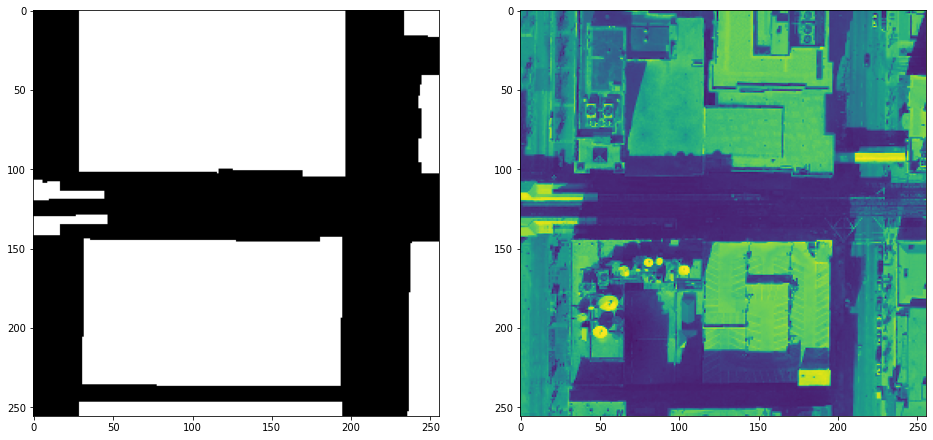

In [7]:
image, mask = dataset[0]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);


In [8]:
valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 7 == 0:
        valid_idx.append(i)
#     else:
    elif i % 7 == 1:
        train_idx.append(i)
        
train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [9]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    
#     pth = torch.load("../input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth")
#     for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
#         del pth[key]
    
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [10]:
model = get_model()
model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

In [11]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 5
best_loss = 10
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(loss.item())
        
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
    
    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'model_best.pth')


        Train | Valid
Epoch |  Loss |  Loss | Time, m




     1│  0.365│  0.278│  4.53


KeyboardInterrupt: 

In [14]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

subm = []

model.load_state_dict(torch.load("./model_best.pth"))
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [17]:
test_mask = pd.read_csv('数据集/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: '数据集/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

In [20]:
subm = pd.DataFrame(subm)
subm.to_csv('./tmp.csv', index=None, header=None, sep='\t')

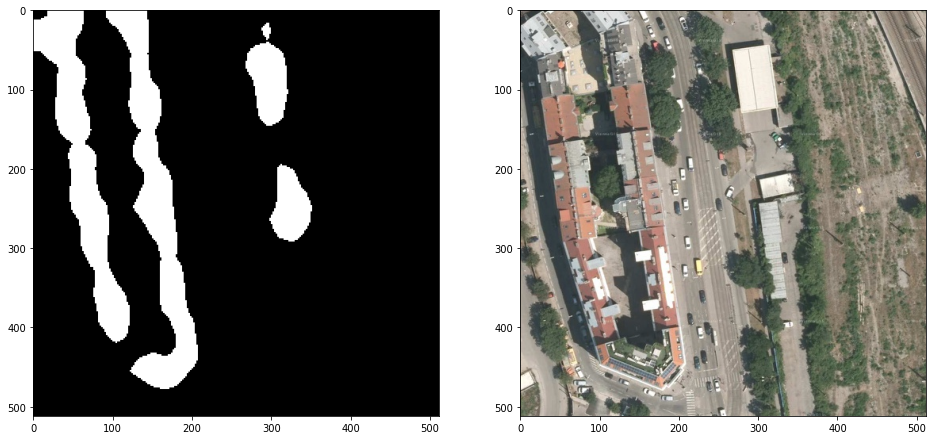

In [23]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(subm[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('数据集/test_a/' + subm[0].iloc[0]));


In [4]:
a  = '''alabaster
argh
asn1crypto
astroid
astropy
atomicwrites
attrs
autopep8
Babel
backcall
backports.functools-lru-cache
backports.shutil-get-terminal-size
backports.tempfile
backports.weakref
beautifulsoup4
bitarray
bkcharts
bleach
bokeh
boto
Bottleneck
brotlipy
certifi
cffi
chardet
click
cloudpickle
clyent
colorama
contextlib2
cryptography
cycler
Cython
cytoolz
dask
decorator
defusedxml
diff-match-patch
distributed
docutils
entrypoints
et-xmlfile
fastcache
filelock
flake8
Flask
fsspec
future
gevent
glob2
gmpy2
greenlet
h5py
HeapDict
html5lib
idna
imageio
imagesize
importlib-metadata
intervaltree
ipykernel
ipython
ipython-genutils
ipywidgets
isort
itsdangerous
jdcal
jedi
jeepney
Jinja2
joblib
json5
jsonschema
keyring
kiwisolver
lazy-object-proxy
libarchive-c
llvmlite
locket
lxml
MarkupSafe
matplotlib
mccabe
mistune
mkl-fft
mkl-random
mkl-service
mock
more-itertools
mpmath
msgpack
multipledispatch
navigator-updater
nbconvert
nbformat
nose
numba
numexpr
numpy
numpydoc
olefile
openpyxl
packaging
pandas
pandocfilters
parso
partd
path
pathlib2
pathtools
patsy
pep8
pexpect
pickleshare
Pillow
pkginfo
pluggy
ply
prometheus-client
prompt-toolkit
psutil
ptyprocess
pycodestyle
pycosat
pycparser
pycurl
pydocstyle
pyflakes
Pygments
pylint
pyodbc
pyOpenSSL
pyparsing
pyrsistent
PySocks
pytest
python-dateutil
python-jsonrpc-server
python-language-server
pytz
PyWavelets
pyxdg
PyYAML
pyzmq
regex
requests
rope
Rtree
ruamel-yaml
scikit-image
scikit-learn
scipy
seaborn
SecretStorage
Send2Trash
simplegeneric
singledispatch
sip
six
snowballstemmer
sortedcollections
sortedcontainers
soupsieve
spyder-kernels
statsmodels
sympy
tables
tblib
terminado
testpath
threadpoolctl
toml
toolz
tornado
tqdm
traitlets
typing-extensions
ujson
unicodecsv
urllib3
watchdog
wcwidth
webencodings
Werkzeug
widgetsnbextension
wrapt
wurlitzer
xlrd
XlsxWriter
xlwt
xmltodict
yapf
zict
zipp
zope.event
zope.interface
'''.split('\n')

In [8]:
print('\n'.join(['pip3 install ' + x for x in a]))

pip3 install alabaster
pip3 install argh
pip3 install asn1crypto
pip3 install astroid
pip3 install astropy
pip3 install atomicwrites
pip3 install attrs
pip3 install autopep8
pip3 install Babel
pip3 install backcall
pip3 install backports.functools-lru-cache
pip3 install backports.shutil-get-terminal-size
pip3 install backports.tempfile
pip3 install backports.weakref
pip3 install beautifulsoup4
pip3 install bitarray
pip3 install bkcharts
pip3 install bleach
pip3 install bokeh
pip3 install boto
pip3 install Bottleneck
pip3 install brotlipy
pip3 install certifi
pip3 install cffi
pip3 install chardet
pip3 install click
pip3 install cloudpickle
pip3 install clyent
pip3 install colorama
pip3 install contextlib2
pip3 install cryptography
pip3 install cycler
pip3 install Cython
pip3 install cytoolz
pip3 install dask
pip3 install decorator
pip3 install defusedxml
pip3 install diff-match-patch
pip3 install distributed
pip3 install docutils
pip3 install entrypoints
pip3 install et-xmlfile
pip3 in